In [46]:
import json
import os
import cv2
from PIL import Image
import numpy as np
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,  classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import seaborn as sns
import gc
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization

In [11]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    
    for root, _, files in os.walk(DIR):
        for file in files:
            if file.endswith('.jpg'):
                PATH = os.path.join(root,file)
                
                img = read(PATH)

                img = cv2.resize(img, (RESIZE,RESIZE))

                IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('train/benign',124))
malign_train = np.array(Dataset_loader('train/malignant',124))
benign_test = np.array(Dataset_loader('test/benign',124))
malign_test = np.array(Dataset_loader('test/malignant',124))




# Create Label

In [12]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [16]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11)

# Split validation set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(
    x_val, y_val, test_size=0.5, random_state=11)

# Display Some Images

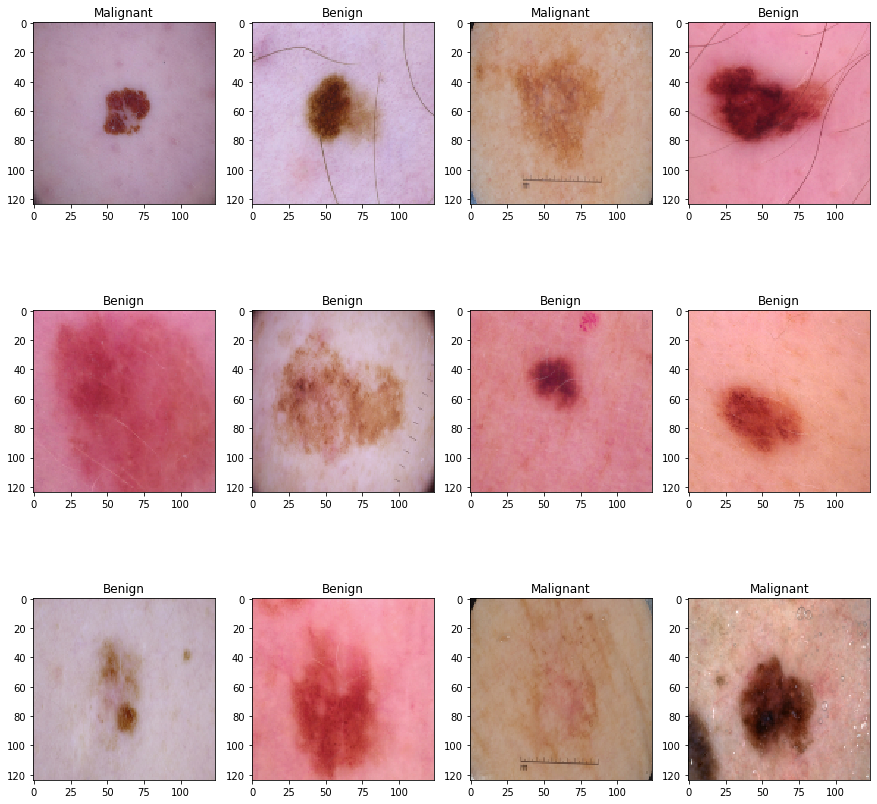

In [17]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    elif np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Malignant')
    else:
        ax.title.set_text('Normal')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [18]:
# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: CNN

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(124, 124, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 122, 122, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 27, 27, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 128)     

In [29]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [30]:
history = model.fit(
    x_train, y_train, 
    batch_size=24,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/15
88/88 [==============================] - ETA: 0s - loss: 1.1835 - accuracy: 0.6633
Epoch 1: val_accuracy improved from -inf to 0.51136, saving model to weights.best.hdf5
88/88 [==============================] - 73s 800ms/step - loss: 1.1835 - accuracy: 0.6633 - val_loss: 0.7463 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 2/15
88/88 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.6961
Epoch 2: val_accuracy improved from 0.51136 to 0.53030, saving model to weights.best.hdf5
88/88 [==============================] - 69s 787ms/step - loss: 0.5781 - accuracy: 0.6961 - val_loss: 0.6722 - val_accuracy: 0.5303 - lr: 0.0010
Epoch 3/15
88/88 [==============================] - ETA: 0s - loss: 0.5666 - accuracy: 0.7141
Epoch 3: val_accuracy improved from 0.53030 to 0.74621, saving model to weights.best.hdf5
88/88 [==============================] - 71s 807ms/step - loss: 0.5666 - accuracy: 0.7141 - val_loss: 0.5742 - val_accuracy: 0.7462 - lr: 0.0010
Epoch 4/15
88/88

In [31]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot: >

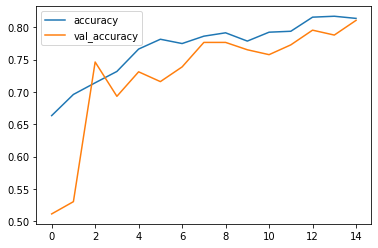

In [32]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
# history_df

<AxesSubplot: >

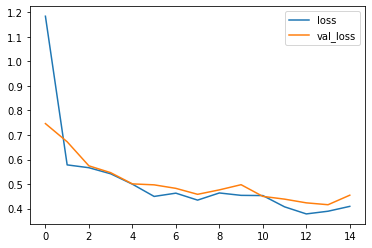

In [33]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [34]:
Y_pred = model.predict(x_test)

9/9 [==============================] - 3s 250ms/step


In [35]:
accuracy_score(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))

0.8181818181818182

### Classification Report

In [36]:
print(classification_report( np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1), target_names=['benign', 'malignant']))

              precision    recall  f1-score   support

      benign       0.88      0.78      0.83       147
   malignant       0.76      0.86      0.81       117

    accuracy                           0.82       264
   macro avg       0.82      0.82      0.82       264
weighted avg       0.83      0.82      0.82       264



### Confusion Matrix

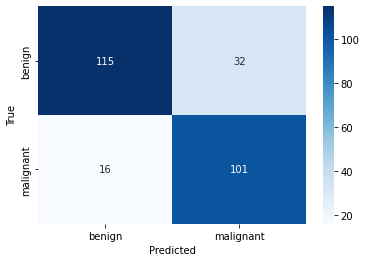

In [40]:
# Create the confusion matrix
cm = confusion_matrix( np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### ROC and AUC Curve

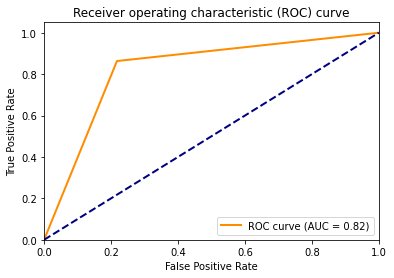

In [43]:
# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve( np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()